<a href="https://colab.research.google.com/github/cxbxmxcx/Practical_AI_on_GCP/blob/master/Chapter_3_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf
keras = tf.keras

In [ ]:
import tensorflow_datasets as tfds
#tfds.disable_progress_bar()

In [ ]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs', split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True, as_supervised=True)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete44RQ7D/cats_vs_dogs-train.tfrecord



Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [ ]:
print(raw_train)
print(raw_validation)
print(raw_test)

<DatasetV1Adapter shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<DatasetV1Adapter shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<DatasetV1Adapter shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


In [ ]:
get_label_name = metadata.features['label'].int2str
import math
def plot_data(data, num_images):
  grid = math.ceil(math.sqrt(num_images))
  plt.figure(figsize=(grid*2,grid*2))
  i = 0
  for image, label in data.take(num_images):
    i+=1
    plt.subplot(grid,grid,i)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image)
    plt.xlabel(get_label_name(label))
  plt.show()

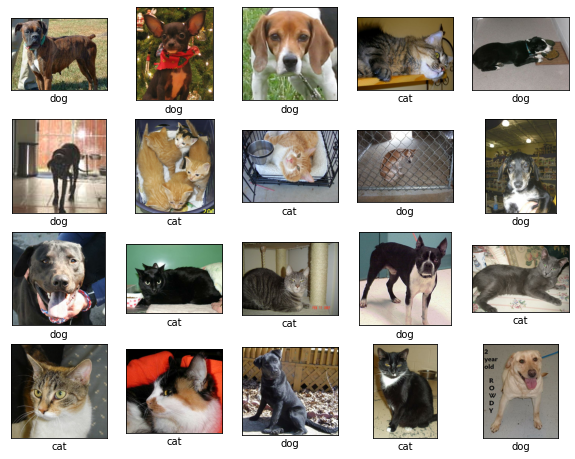

In [ ]:
plot_data(raw_train, 20)

In [ ]:
IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [ ]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

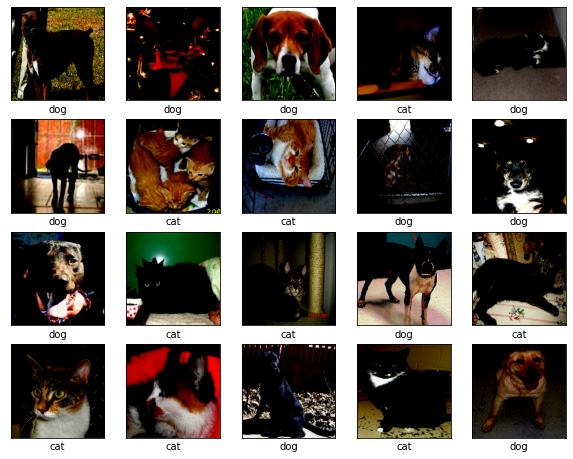

In [ ]:
plot_data(train, 20)

In [ ]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [ ]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [ ]:
for image_batch, label_batch in train_batches.take(1):
   pass

image_batch.shape

TensorShape([32, 160, 160, 3])

In [ ]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.VGG19(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

80142336/80134624 [==============================] - 2s 0us/step


In [ ]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 512)


In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


In [ ]:
prediction_layer = keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 5, 5, 512)         20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 20,024,897
Trainable params: 513
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
len(model.trainable_variables)

2

In [ ]:
metadata.splits['train']

<tfds.core.SplitInfo num_examples=23262>

In [ ]:
initial_epochs = 10
validation_steps = 20

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

20/20 [==============================] - 1s 60ms/step - loss: 8.0380 - accuracy: 0.4703


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 8.04
initial accuracy: 0.47


In [ ]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

Epoch 1/10
582/582 [==============================] - 65s 112ms/step - loss: 1.5600 - accuracy: 0.5809 - val_loss: 0.5303 - val_accuracy: 0.7657
Epoch 2/10
582/582 [==============================] - 64s 111ms/step - loss: 0.4103 - accuracy: 0.8304 - val_loss: 0.3548 - val_accuracy: 0.8586
Epoch 3/10
582/582 [==============================] - 64s 110ms/step - loss: 0.3117 - accuracy: 0.8804 - val_loss: 0.3120 - val_accuracy: 0.8775
Epoch 4/10
582/582 [==============================] - 65s 111ms/step - loss: 0.2759 - accuracy: 0.8974 - val_loss: 0.2916 - val_accuracy: 0.8904
Epoch 5/10
582/582 [==============================] - 64s 111ms/step - loss: 0.2540 - accuracy: 0.9070 - val_loss: 0.2768 - val_accuracy: 0.8981
Epoch 6/10
582/582 [==============================] - 64s 110ms/step - loss: 0.2430 - accuracy: 0.9118 - val_loss: 0.2780 - val_accuracy: 0.9046
Epoch 7/10
582/582 [==============================] - 65s 111ms/step - loss: 0.2332 - accuracy: 0.9154 - val_loss: 0.2583 - val_ac

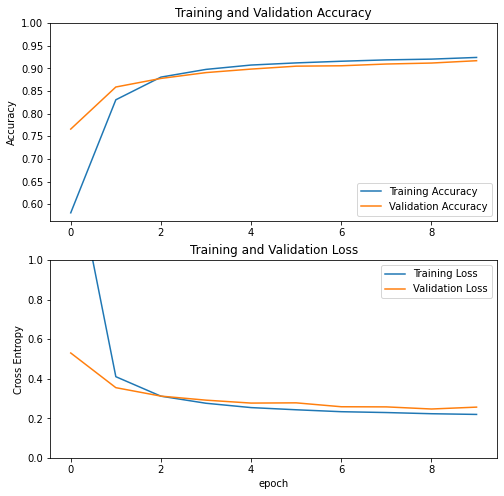

In [ ]:
def plot_history():
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.ylim([0,1.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

plot_history()

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  22


In [ ]:
fine_tune_at = 15

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 5, 5, 512)         20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 20,024,897
Trainable params: 11,799,553
Non-trainable params: 8,225,344
_________________________________________________________________


In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch =  history.epoch[-1],
                         validation_data=validation_batches)

Epoch 10/20
582/582 [==============================] - 74s 127ms/step - loss: 0.2217 - accuracy: 0.9450 - val_loss: 0.2018 - val_accuracy: 0.9497
Epoch 11/20
582/582 [==============================] - 73s 126ms/step - loss: 0.1287 - accuracy: 0.9697 - val_loss: 0.2944 - val_accuracy: 0.9475
Epoch 12/20
582/582 [==============================] - 73s 126ms/step - loss: 0.0838 - accuracy: 0.9825 - val_loss: 0.2364 - val_accuracy: 0.9626
Epoch 13/20
582/582 [==============================] - 73s 125ms/step - loss: 0.0658 - accuracy: 0.9899 - val_loss: 0.2324 - val_accuracy: 0.9703
Epoch 14/20
582/582 [==============================] - 72s 123ms/step - loss: 0.0541 - accuracy: 0.9937 - val_loss: 0.2857 - val_accuracy: 0.9665
Epoch 15/20
582/582 [==============================] - 72s 123ms/step - loss: 0.0448 - accuracy: 0.9946 - val_loss: 0.3414 - val_accuracy: 0.9596
Epoch 16/20
582/582 [==============================] - 73s 125ms/step - loss: 0.0404 - accuracy: 0.9961 - val_loss: 0.2623 -

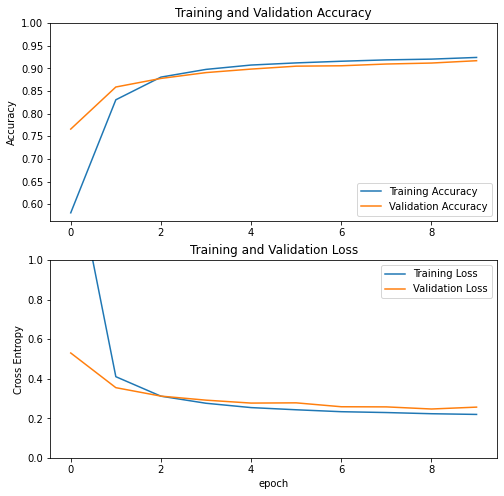

In [ ]:
plot_history()